# Problem Set 3: Convolutional Neural Networks 

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size 
        self.stride = stride 
        self.padding = padding
        self.bias = bias

        HH, WW = kernel_size
        self.w = torch.randn(out_channels, in_channels, HH, WW).requires_grad_(True)
        self.b = torch.randn(out_channels).requires_grad_(True)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape
        HH, WW = self.kernel_size
        pad = self.padding
        stride = self.stride

        H_ = (H + 2*pad - HH) // stride + 1
        W_ = (W + 2*pad - WW) // stride + 1

        X = torch.zeros(N, self.in_channels, H+2*pad, W+2*pad)
        X[:, :, pad:H+pad, pad:W+pad] = x
        out = torch.zeros(N, self.out_channels, H_, W_)

        for n in range(N):
            for f in range(self.out_channels):
                for i in range(H_):
                    for j in range(W_):
                        i_ = i*stride
                        j_ = j*stride
                        out[n, f, i, j] += torch.sum(X[n, :, i_:i_+HH, j_:j_+WW] * self.w[f])
                if self.bias:
                    out[n,f,:,:] += self.b[f]

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [ ]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.kernel_size = kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N, C, H, W = x.shape
        HH, WW = self.kernel_size
        H_, W_ = H-HH+1, W-WW+1
        out = torch.zeros(N, C, H_, W_)
        for n in range(N):
            for c in range(C):
                for i in range(H_):
                    for j in range(W_):
                        out[n, c, i, j] = torch.max(x[n, c, i:i+HH, j:j+WW])

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [ ]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias = None
        
        self.weight = torch.randn(in_channels, out_channels)
        self.weight = self.weight / torch.sqrt(in_channels)
        self.weight = self.weight.requires_grad_(True)
        if bias:
            self.bias = torch.randn(out_channels).requires_grad_(True)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N = x.shape[0]
        H = self.in_channels
        H_ = self.out_channels

        D = 1
        for i in x.shape[:-1]:
            D *= i

        X = x.reshape(D, H)
        out = X @ self.weight
        
        if self.bias is not None:
            out += self.bias
        
        out = out.reshape(x.shape[:-1]+(H_,))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [ ]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum - the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        shape = (1, num_features, 1, 1)

        self.gamma = torch.ones(shape, requires_grad=True)
        self.beta = torch.zeros(shape, requires_grad=True)

        self.running_mean = torch.zeros(shape)
        self.running_var = torch.ones(shape)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        norm = None

        if self.training:
            mean = x.mean(dim=(0,2,3), keepdim=True)
            var = x.var(dim=(0,2,3), keepdim=True)
            norm = (x-mean)/torch.sqrt(var+self.eps)

            self.running_mean = self.running_mean*self.momentum + mean*(1-self.momentum)
            self.running_var = self.running_var*self.momentum + var*(1-self.momentum)
        else:
            norm = (x-self.running_mean)/torch.sqrt(self.running_var+self.eps)
            
        out = self.gamma * norm + self.beta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

**Answer**

Check initial loss and overfit a small sample within small epochs at first. Use coarse grid to find best range of hyperparams and later fine-tune them more precisely.

In [27]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [28]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [29]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

transform_train = T.Compose(
    [T.RandomHorizontalFlip(),
     T.ToTensor(),
     T.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])

transform_test = T.Compose(
    [T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])

##############################################################
#                       END OF YOUR CODE                     #
##############################################################




Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html).
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [30]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

data_dir = './data'

training_data = dset.CIFAR10(data_dir, download=True, train=True, transform=transform_train)
testing_data = dset.CIFAR10(data_dir, download=True, train=False, transform=transform_test)

batch_size = 64
loader_train = DataLoader(training_data, batch_size=batch_size)
loader_test = DataLoader(testing_data, batch_size=batch_size)

##############################################################
#                       END OF YOUR CODE                     #       
##############################################################



Files already downloaded and verified
Files already downloaded and verified


In [31]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
    

print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        

def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #check_accuracy(loader_val, model)
                print()

In [32]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

model = ResNet18()
optimizer = optim.Adam(model.parameters(),weight_decay=5e-6)

def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #check_accuracy(loader_val, model)
                print()
        optimizer.param_groups[0]['lr'] *= 0.9

##############################################################
#                       END OF YOUR CODE                     #
##############################################################


# define and train the network
# model = ResNet18()
# optimizer = optim.Adam(model.parameters())

train_part(model, optimizer, epochs = 10)


# report test set accuracy

check_accuracy(loader_test, model)


# save the model
torch.save(model.state_dict(), 'model.pt')

782
Epoch: 0, Iteration 0, loss = 4.4925

Epoch: 0, Iteration 100, loss = 1.7355

Epoch: 0, Iteration 200, loss = 1.5730

Epoch: 0, Iteration 300, loss = 1.4280

Epoch: 0, Iteration 400, loss = 1.3329

Epoch: 0, Iteration 500, loss = 1.4355

Epoch: 0, Iteration 600, loss = 1.0170

Epoch: 0, Iteration 700, loss = 1.1172

782
Epoch: 1, Iteration 0, loss = 0.9744

Epoch: 1, Iteration 100, loss = 0.9415

Epoch: 1, Iteration 200, loss = 0.6455

Epoch: 1, Iteration 300, loss = 1.0298

Epoch: 1, Iteration 400, loss = 0.8039

Epoch: 1, Iteration 500, loss = 1.1077

Epoch: 1, Iteration 600, loss = 0.6867

Epoch: 1, Iteration 700, loss = 0.8960

782
Epoch: 2, Iteration 0, loss = 0.7147

Epoch: 2, Iteration 100, loss = 0.6822

Epoch: 2, Iteration 200, loss = 0.4378

Epoch: 2, Iteration 300, loss = 0.4748

Epoch: 2, Iteration 400, loss = 0.6179

Epoch: 2, Iteration 500, loss = 0.7899

Epoch: 2, Iteration 600, loss = 0.5070

Epoch: 2, Iteration 700, loss = 0.5458

782
Epoch: 3, Iteration 0, loss = 

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

A:

1. Low-level features are more of details of the images, especially lines and edges. High-level features, which are built in top of low-level features, focus on larger shapes and go more abstract. So low-level features can represent a spicific object while high-level features contain information of a whole class.

2. The performance is good enough. The training log shows the loss is going down in general. The feature maps successfully extract both concrete low-level features and abstract high level-features. An accuracy of about 87% is satisfying as the training epoch is only set to 10.

3. Slightly change the input image (darkening, adding some mask, etc) to check its robustness. Draw heat-map of features on the input image to see whether the features it learns is interpretable.


<Figure size 432x288 with 0 Axes>

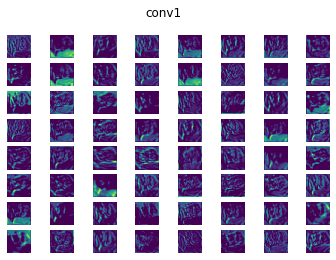

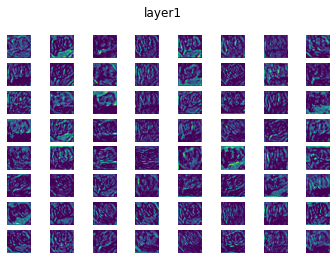

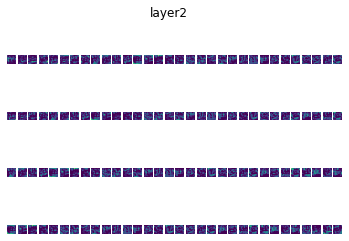

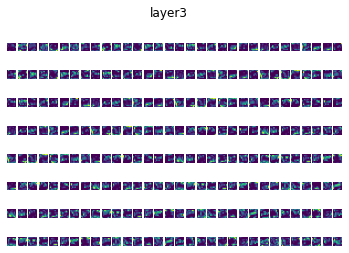

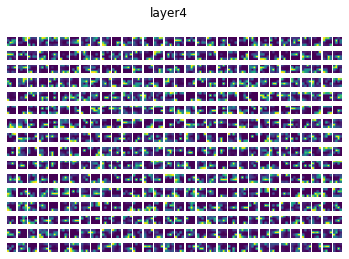

In [ ]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = testing_data[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')